In [1]:
import os

os.chdir("../")

In [2]:
import pandas as pd

from src.io.path_definition import get_file
from train.src.run_LSTM2LSTM import data_preparation

cancel_target = pd.read_csv(get_file(os.path.join('data', 'cancel_dataset_target.csv')), index_col=0)
date_feature = pd.read_csv(get_file(os.path.join('data', 'cancel_dataset_date_feature.csv')), index_col=0)

numerical_features, date_feature = data_preparation(hotel_id=57, date_feature=date_feature, cancel_target=cancel_target)

In [3]:
date_index = date_feature.index
date_index = [index.replace("/", "-") for index in date_index]
date_feature.index = date_index

In [4]:
date_feature.head(5)

,season,sp_date,midd,sallery,workingday,days2vecation,week,is_rest_day,vecation,is_event,...,w_vecation,vecation_days,Precp,PrecpHour,SunShine,Temperature,weekdate,cov_policy,canceled,canceled_label
2019-2-25,1,N,0,0,1,3,MON,0,0,0,...,0,1.00,0.0,0.0,9.6,19.8,1,0,2,2
2019-2-26,1,N,0,0,1,2,TUE,0,0,0,...,0,1.00,0.0,0.0,6.9,20.3,2,0,1,1
2019-2-27,1,N,0,0,1,1,WED,0,0,0,...,0,1.00,0.0,0.0,8.0,21.8,3,0,1,1
2019-2-28,1,N,0,0,0,0,THU,1,1,0,...,0,0.25,0.0,0.0,8.7,22.2,4,0,1,1
2019-3-1,1,N,0,0,0,0,FRI,1,1,0,...,0,0.50,0.0,0.0,8.5,21.3,5,0,1,1


In [5]:
bank_holiday_condition = (~date_feature['week'].isin(['SAT', 'SUN'])) & (date_feature['is_rest_day']==1)

bank_holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(date_feature[bank_holiday_condition].index.tolist()),
    'lower_window': -1,
    'upper_window': 1
})

weekend_condition = date_feature['week'].isin(['SAT', 'SUN'])

weekend = pd.DataFrame({
    'holiday': 'weekend',
    'ds': pd.to_datetime(date_feature[weekend_condition].index.tolist()),
    'lower_window': -1,
    'upper_window': 1
})

holidays = pd.concat((bank_holiday, weekend))

In [6]:
holidays.head(5)

,holiday,ds,lower_window,upper_window
0,holiday,2019-02-28,-1,1
1,holiday,2019-03-01,-1,1
2,holiday,2019-04-04,-1,1
3,holiday,2019-04-05,-1,1
4,holiday,2019-05-01,-1,1


In [7]:
holidays.tail(5)

,holiday,ds,lower_window,upper_window
355,weekend,2022-07-24,-1,1
356,weekend,2022-07-30,-1,1
357,weekend,2022-07-31,-1,1
358,weekend,2022-08-06,-1,1
359,weekend,2022-08-07,-1,1


In [31]:
from prophet import Prophet

cancel_df = date_feature[['canceled']]
cancel_df.rename(columns={'canceled': 'y'}, inplace=True)

cancel_df.index.name = 'ds'
cancel_df.reset_index(inplace=True)

m = Prophet(holidays=holidays, weekly_seasonality=True, seasonality_mode='multiplicative')

C:\Users\MengChieh\Miniconda3\envs\hotelCancellation\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear' or 'logistic' to specify a linear or logistic
    trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range`

In [9]:
cancel_df.head(5)

,ds,y
0,2019-2-25,2
1,2019-2-26,1
2,2019-2-27,1
3,2019-2-28,1
4,2019-3-1,1


In [32]:
m.fit(cancel_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
fit_value = m.predict(cancel_df[['ds']])

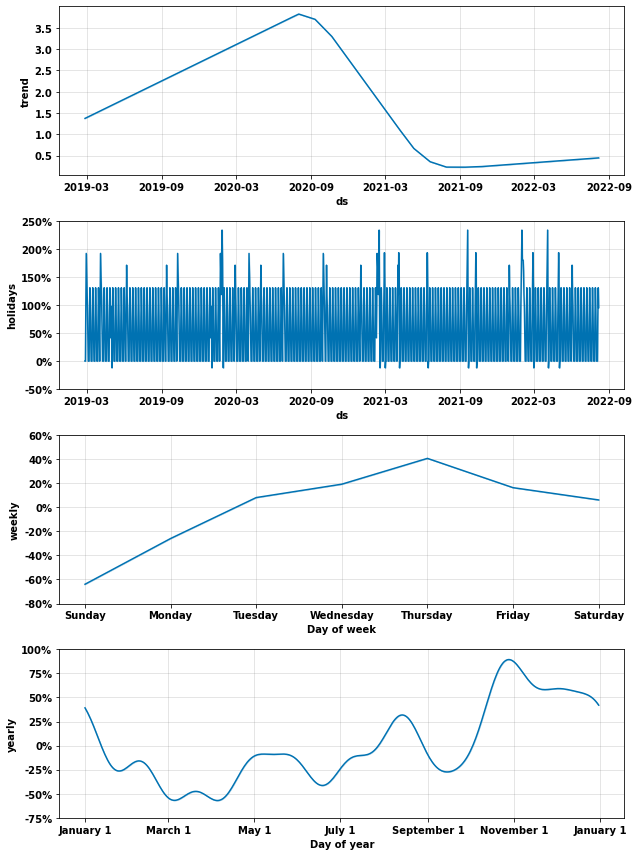

In [34]:
# https://github.com/facebook/prophet/issues/396
# You can place a ';' behind your statement in order to get the plot only once. I think this is due to the fact that the plot is already rendered in the function.

m.plot_components(fit_value);

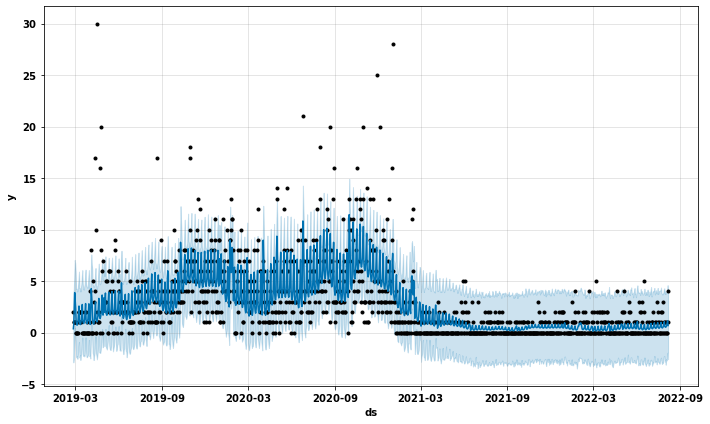

In [35]:
m.plot(fit_value);

In [36]:
# fit_value

In [37]:
# fit_value.columns

In [38]:
# Prediction:

future_data_frame = m.make_future_dataframe(28);

In [39]:
future_data_frame

,ds
0,2019-02-25
1,2019-02-26
2,2019-02-27
3,2019-02-28
4,2019-03-01
...,...
1283,2022-08-31
1284,2022-09-01
1285,2022-09-02
1286,2022-09-03


In [40]:
prediction = m.predict(future_data_frame)

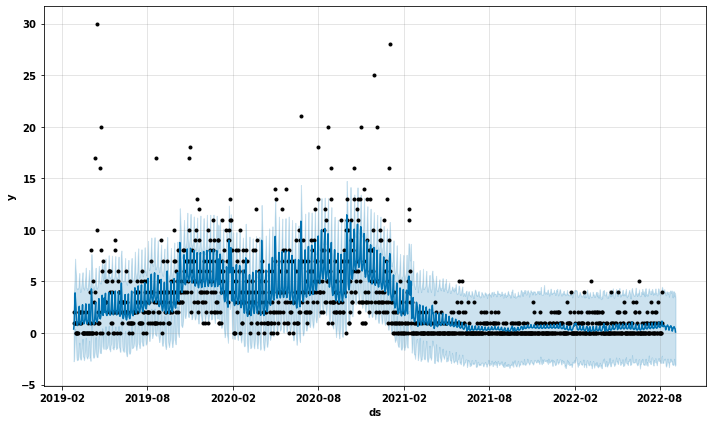

In [41]:
m.plot(prediction);

In [25]:
cancel_df.tail(5)

,ds,y
1255,2022-8-3,1
1256,2022-8-4,0
1257,2022-8-5,0
1258,2022-8-6,1
1259,2022-8-7,4


In [26]:
future_data_frame.tail(30)

,ds
1258,2022-08-06
1259,2022-08-07
1260,2022-08-08
1261,2022-08-09
1262,2022-08-10
1263,2022-08-11
1264,2022-08-12
1265,2022-08-13
1266,2022-08-14
1267,2022-08-15


In [ ]:
# 算MAPE
# neural prophet